# Latent Semantic Indexing  (潜在意味インデクシング)

単語文章行列`C`を、SVDを用いて小さい階数の行列で近似する。
クエリも同様に定数表現に書き換えることにより文章の類似度が計算可能となる。
この処理はLSIといsて知られている。

In [8]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
%matplotlib inline

In [2]:
font = "/Library/Fonts/OsakaMono.ttf"
# http://ossipedia.ipa.go.jp/ipafont/index.html
prop = font_manager.FontProperties(fname=font)


In [5]:
C = np.array([
    [1, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 0],
    [0, 0, 0, 1, 0, 1]
])


In [6]:
recipes = ['親子丼','鶏肉ときのこのソテー', '丸ごと玉ねぎ', 'ホウレンソウと卵の炒めもの','卵焼き','ホウレンソウの胡麻和え']
ingredients = ['玉ねぎ', 'きのこ', '鶏肉', '卵', 'ホウレンソウ']
df = pd.DataFrame(C,columns=recipes)
#                  columns=['d{i}'.format(i=i) for i in range(1,7)])
df.rename(index={ i:v for i, v in enumerate(ingredients)})

,親子丼,鶏肉ときのこのソテー,丸ごと玉ねぎ,ホウレンソウと卵の炒めもの,卵焼き,ホウレンソウの胡麻和え
玉ねぎ,1,0,1,0,0,0
きのこ,0,1,0,0,0,0
鶏肉,1,1,0,0,0,0
卵,1,0,0,1,1,0
ホウレンソウ,0,0,0,1,0,1


## 表 1 材料とレシピの行列

## 解決したい問題

上記の表1は各レシピに含まれる材料を示したもので、材料を含む場合は**1**、含まない場合は**0**とする。
上記の行列を示した行列を$C$とする。
今、ユーザがクエリ$q = (0, 1, 1, 1, 0)^{t}$つまり、きのこ、鶏肉、卵を使った料理を探したいとき、
一番近い料理をユーザに推薦したい。どれを推薦すれば良いかの問題を考える。

はじめに、一番簡単な方法として`cosine`類似度がある。次に、行列 $C$を近似したも$\widetilde{C}$を生成し、同様にクエリも近似することで、
計算量を削減し、さらに潜在的に含まれる意味、ノイズを除去をしてくれるLSIを紹介する。

## Cosine類似度

In [29]:
from scipy.spatial.distance import cosine
q = np.array([0, 1, 1, 1, 0]) #きのこ、鶏肉、卵を使った料理
sorted([(cosine(q, C[:,i]), recipes[i]) for i in range(C.shape[1])])

[(0.18350341907227408, '鶏肉ときのこのソテー'),
 (0.33333333333333326, '親子丼'),
 (0.42264973081037416, '卵焼き'),
 (0.59175170953613709, 'ホウレンソウと卵の炒めもの'),
 (1.0, 'ホウレンソウの胡麻和え'),
 (1.0, '丸ごと玉ねぎ')]

上記より、クエリq=(きのこ、鶏肉、卵)を使った食材での検索では、
鶏肉ときのこソテーが一番近く、親子丼が次に近い事がわかる。
よって、cosine類似度では、*鶏肉ときのこソテー*が推薦される

cosine類似の問題点としては、ノイズが入っていたとしてもまとめに入ってしまう。
さらに、今回は**5**次元で問題を考えているが実際は**300**以上になってしまうと考えられる。
そのため、cosine類似度では計算に時間がかかってしまい、現実時間内に終わらない可能性がある。
そこで、次元を削減し、潜在的意味も考慮できるLSIを試す。その前に、次元を削減する方法としては**truncated SVD**を用いる。

## Truncated SVD and LSI

In [31]:
U,D,Vt = np.linalg.svd(C) # SVDによって、行列Cを三つの行列に分解する。
np.set_printoptions(3, suppress=True)
print("U:\n", U)
print("Σ:\n", np.diag(D))
print("Vt:\n", Vt)



U:
 [[ 0.44  -0.296 -0.569  0.577 -0.246]
 [ 0.129 -0.331  0.587  0.    -0.727]
 [ 0.476 -0.511  0.368  0.     0.614]
 [ 0.703  0.351 -0.155 -0.577 -0.16 ]
 [ 0.263  0.647  0.415  0.577  0.087]]
Σ:
 [[ 2.163  0.     0.     0.     0.   ]
 [ 0.     1.594  0.     0.     0.   ]
 [ 0.     0.     1.275  0.     0.   ]
 [ 0.     0.     0.     1.     0.   ]
 [ 0.     0.     0.     0.     0.394]]
Vt:
 [[ 0.749  0.28   0.204  0.447  0.325  0.121]
 [-0.286 -0.528 -0.186  0.626  0.22   0.406]
 [-0.28   0.749 -0.447  0.204 -0.121  0.325]
 [-0.     0.     0.577  0.    -0.577  0.577]
 [ 0.528 -0.286 -0.626 -0.186 -0.406  0.22 ]
 [ 0.    -0.    -0.    -0.577  0.577  0.577]]


上記のように、**SVD(singular-value decomposition, 特異行列分解)**をすると

- $U$: **玉ねぎ, きのこ, 鶏肉, 卵, ホウレンソウ** (食材)を行とするクエリ行列ができ
- $V^t$: **親子丼,鶏肉ときのこのソテー, 丸ごと玉ねぎ, ホウレンソウと卵の炒めもの,卵焼き,ホウレンソウの胡麻和え** レシピを列に持つレシピ行列ができます。
- $\sum$:特異値

今の特徴空間は5次元あるが、実際には5次元でなくても少ない次元で
この特徴空間を表現できることが知られている。これは特徴数と累積寄与率の関係を見るとわかる。（詳しくは、わかりやすいパターン認識。章6p138）

ここで、特異値$\sum$の$\sum_{2}$以降の対角要素は全て`0`にします。
$\sum_{2}×V^t$をすると、レシピ行列$V^t$の3行目以降は全て`0`になるので、
無視できます。

$\sum_{2}$の低近似されたSVD(truncated SVD) は

$C_{2} = U_{2}\sum_{2}V_{2}^{t}$

となる

In [36]:
#np.diag(D)[:2]
#Vt[:2]
#U[:2]
D2 = np.array([v if i < 2 else 0 for i,v in enumerate(D)])
#U.dot(np.diag(D2))

In [39]:
C2 = np.dot(U[:,:2]*D[:2], Vt[:2])
C2

array([[ 0.848,  0.516,  0.282,  0.13 ,  0.206, -0.076],
       [ 0.361,  0.358,  0.155, -0.206, -0.025, -0.18 ],
       [ 1.003,  0.718,  0.361, -0.051,  0.155, -0.206],
       [ 0.978,  0.13 ,  0.206,  1.029,  0.617,  0.411],
       [ 0.13 , -0.386, -0.076,  0.899,  0.411,  0.487]])

上記のような、近似された行列$C$,

$\widetilde{C_{2}} \approx C $を得られる

近似の精度は Frobenius精度によって計算できる(0に近いほど良い)

In [40]:
np.linalg.norm(C-C2,'fro') #frobeniusによる精度

1.6677932876555253

In [479]:
C1 = np.dot(U[:,:1]*D[:1], Vt[:1])
np.linalg.norm(C-C1, 'fro') #frobenius

2.3072905296136073

In [169]:
truncated_SVD = lambda k: np.dot(U[:,:k]*D[:k], Vt[:k])

In [41]:
#np.argmin([np.linalg.norm(C-truncated_SVD(k), 'fro') for k in range(1, D.size)])

In [199]:
np.linalg.norm(C-truncated_SVD(4), 'fro')

0.39391525049455717

In [204]:
U[:, :2]

array([[ 0.44 , -0.296],
       [ 0.129, -0.331],
       [ 0.476, -0.511],
       [ 0.703,  0.351],
       [ 0.263,  0.647]])

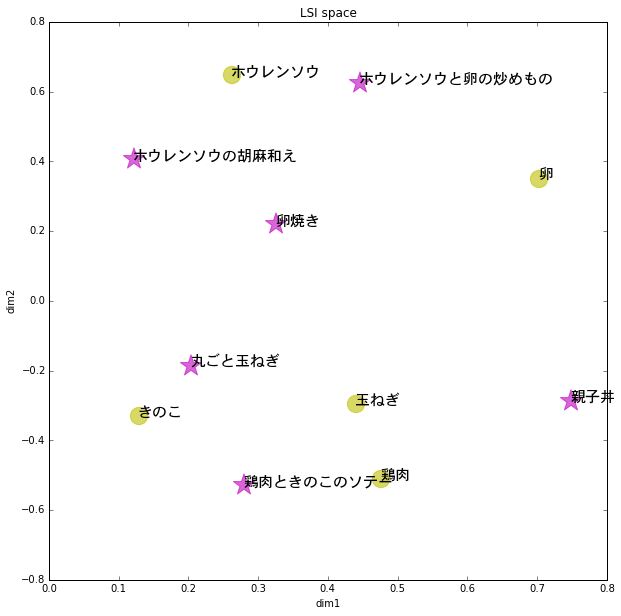

In [474]:
plt.figure(figsize=(10,10))
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.title('LSI space')
plt.scatter(U[:,0], U[:,1], color='y', marker='o', s=300, alpha=0.6)
for i, ingredient in enumerate(ingredients):
    plt.annotate(ingredient, xy=(U[i,0],U[i,1]), fontproperties=prop,size='15')

plt.scatter(Vt[:2][0], Vt[:2][1], color='m', marker='*', s=500, alpha=0.6)
for i, recipe in enumerate(recipes):
    plt.annotate(recipe, xy=(Vt[:2][0][i],Vt[:2][1][i]), fontproperties=prop,size='15')


近似された$C_{2}$を使うことによって、次元削減をすることにより2次元空間に写像できる。

ここで、クエリq: きのこ、鶏肉、卵で検索されたとする。

$q = (0, 1, 1, 1, 0)^T $

どんなレシピを出すのが最適か?

2D空間でqueryベクトルを計算すると

$q_k = q^TU_{k}\sum_{k}^{-1}$

$q = (0.605, -0.309)$

が得られる

In [401]:
q = np.array([0, 1, 1, 1, 0]) #きのこ、鶏肉、卵を使った料理

In [44]:
D2_inv = np.linalg.inv(np.diag(D[:2]))
D2_inv

array([[ 0.462,  0.   ],
       [ 0.   ,  0.627]])

In [45]:
q2 = np.dot(q, U[:,:2].dot(D2_inv))
q2

array([ 0.605, -0.309])

上記でqを2次元空間に写像したベクトルを得る。
これを、図にマップすると

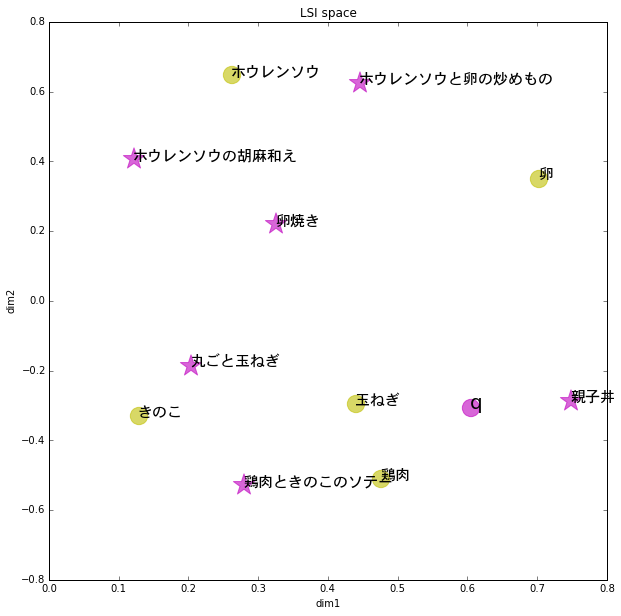

In [484]:
plt.figure(figsize=(10,10))
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.title('LSI space')
plt.scatter(U[:,0], U[:,1], color='y', marker='o', s=300, alpha=0.6)
for i, ingredient in enumerate(ingredients):
    plt.annotate(ingredient, xy=(U[i,0],U[i,1]), fontproperties=prop,size='15')

plt.scatter(Vt[:2][0], Vt[:2][1], color='m', marker='*', s=500, alpha=0.6)
for i, recipe in enumerate(recipes):
    plt.annotate(recipe, xy=(Vt[:2][0][i],Vt[:2][1][i]), fontproperties=prop,size='15')

plt.scatter(*q2, s=300, alpha=0.6, color='m')
plt.annotate('q', xy=(q2[0],q2[1]), size='20')


新しいクエリqは, 親子丼に一番近そうに見える。
ここで、全てのレシピに対して $cosin$類似度を算出してみる。


In [46]:
cosine_similarity = [(cosin(q2,Vt[:2,i]),recipes[i]) for i in range(Vt[:2].shape[1])] 
# where vt[:2, i] is document i (i=1..6)
sorted(cosine_similarity)
    
    

[(0.0056477105174975728, '親子丼'),
 (0.035634379966100527, '丸ごと玉ねぎ'),
 (0.18161668681247489, '鶏肉ときのこのソテー'),
 (0.51677502397478592, '卵焼き'),
 (0.85232680396680982, 'ホウレンソウと卵の炒めもの'),
 (1.1798513530660295, 'ホウレンソウの胡麻和え')]

図からも明らかのように、親子丼が一番近い。
よって、クエリqには親子丼を推薦するのが良い。

このように次元を削減することで、計算量を削減できるのと
ノイズの除去、潜在的な意味を含むことを期待できる。
だが、LSIでは、2008年時点で100万文章を超える成功例は出ていないらしい。